In [ ]:
from google.colab import drive

drive.mount("/content/drive")
import numpy as np
import sklearn as skl
import pandas as pd

import scipy.spatial
import matplotlib.pyplot as plt

data = np.loadtxt(
    "/content/drive/MyDrive/Colab Notebooks/amath 582 lecture notes/reports /4/house-votes-84.data",
    delimiter=",",
    dtype=str,
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1
> Proprecessing data


In [ ]:
# y for party affiliation - republican for 1 and democrat for -1
# y shape = (435,)
y = np.array([1 if i == "republican" else -1 for i in data[:, 0]])

# x for input votes - y for 1, ? for 0, and n for -1
# x shape = (435,16)
x = np.array(
    [[1 if i == "y" else (0 if i == "?" else -1) for i in j] for j in data[:, 1:]]
)

# Task 2 
> Spectral Clustering


In [45]:
N = len(y)  # 435
dist = scipy.spatial.distance_matrix(x, x, p=2)

# define gaussian weight function
def gaussian_weight(r: int, sgm: int) -> int:
    return np.exp(-r * r / (2 * (2**sgm) ** 2))

Set $\sigma =1$ as starting point

In [46]:
sgm = 1

# similarity graph W
W = gaussian_weight(dist, sgm)
d = np.sum(W, axis=1)
D = np.diag(d)

# graph Laplacian
L = D - W
ll, VV = np.linalg.eigh(L)
idx = ll.argsort()
l = ll[idx]
V = VV[:, idx]

# using the second eigenvector q1
FX = V[:, 1]
FX = FX / np.abs(FX).max()

# sign(q1) as classifier
results = np.sign(FX)
missClassified_num = sum(list(map(lambda x: results[x] != y[x], range(N))))
score = 1 - missClassified_num / N

# since the classifier doesn't tell which is republican or democrat
score = max(score, 1 - score)
print(score, end="\n")

0.8781609195402299


## setting $\sigma = (0,4]$ 


0.8781609195402299
0.8758620689655172
0.8758620689655172
0.8758620689655172
0.8781609195402299
0.8804597701149426
0.8781609195402299
0.8781609195402299
0.8804597701149425
0.8804597701149426
0.8804597701149426
0.8827586206896552
0.8827586206896552
0.8827586206896552
0.8827586206896552
0.8827586206896552
0.8827586206896552
0.8827586206896552
0.8827586206896552
0.8827586206896552
[2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4. ]

max accuracy found to be: 0.88276
best sigma found to be: 2.40000 ( the lowest sigma to has best accuracy)


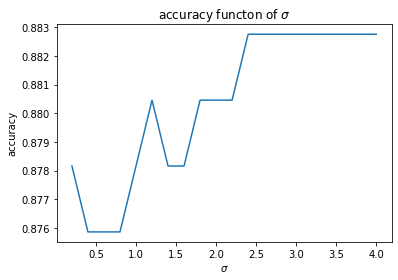

In [47]:
# define sigmas
K_sgm = 21
sgm = np.linspace(0, 4, K_sgm)[1:]

accuracy = []
for i in range(len(sgm)):
    W = gaussian_weight(dist, sgm[i])

    d = np.sum(W, axis=1)
    D = np.diag(d)

    L = D - W
    ll, VV = np.linalg.eigh(L)

    idx = ll.argsort()
    l = ll[idx]
    V = VV[:, idx]
    # using the second eigenvector q1
    FX = V[:, 1]
    FX = FX / np.abs(FX).max()
    # sign(q1) as classifier
    results = np.sign(FX)

    missClassified_num = sum(list(map(lambda x: results[x] != y[x], range(N))))
    score = 1 - missClassified_num / N
    score = max(score, 1 - score)
    accuracy.append(score)

    print(score, end="\n")
print(sgm[np.where(accuracy == max(accuracy))])
print("\nmax accuracy found to be: %0.5f" % max(accuracy))
sgm_star = sgm[np.where(accuracy == max(accuracy))][0]
print(
    "best sigma found to be: %0.5f ( the lowest sigma to has best accuracy)" % sgm_star
)

plt.plot(sgm, accuracy)
plt.title("accuracy functon of $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("accuracy")
plt.show()

Here, we see that the $\sigma^*$ could be multiple values, and we chose $\sigma^* = 2.4000$
## Visualization



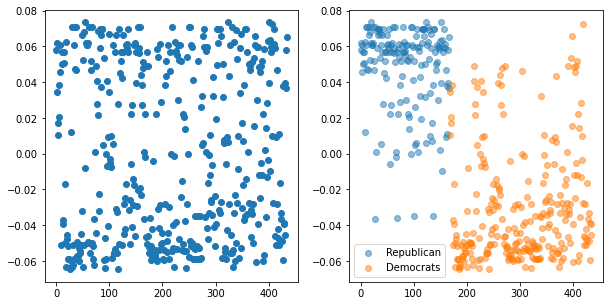

In [48]:
# use the best sigma
W = gaussian_weight(dist, sgm_star)

d = np.sum(W, axis=1)
D = np.diag(d)
L = D - W
ll, VV = np.linalg.eigh(L)
idx = ll.argsort()
l = ll[idx]
V = VV[:, idx]

# using the second eigenvector q1
FX = V[:, 1]

# index of where y=['republican'],['democrat]
idx = [[], []]
for i in range(N):
    if y[i] == 1:
        idx[0].append(i)
    if y[i] == -1:
        idx[1].append(i)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot the unordered eigenvector q1
ax[0].scatter(list(range(N)), FX)

# plot the first 168 republican, and then the 267 democrats for the eigenvector q1
ax[1].scatter(list(range(len(idx[0]))), FX[idx[0]], cmap="hsv", alpha=0.5)
ax[1].scatter(list(range(len(idx[0]), N)), FX[idx[1]], cmap="jet", alpha=0.5)
ax[1].legend(["Republican", "Democrats"])

# Task 3 
> Semi-supervised Learning


In [49]:
# define parameters
M = [2, 3, 4, 5, 6]
J = [5, 10, 20, 40]
sgm_star = sgm[10]

accuracy = []
for i in M:
    for j in J:
        W = gaussian_weight(dist, sgm_star)

        d = np.sum(W, axis=1)
        D = np.diag(d)
        L = D - W
        ll, VV = np.linalg.eigh(L)
        iddx = ll.argsort()
        l = ll[iddx]
        V = VV[:, iddx]
        FX = V[:, :i]
        # A matrix , b vector
        A = FX[:j]
        b = y[:j]
        from sklearn.linear_model import LinearRegression

        # linear regression fit
        reg = LinearRegression().fit(A, b)
        # the y classifier
        result = np.sign(np.dot(FX, reg.coef_))
        missClassified_num = sum(list(map(lambda x: result[x] != y[x], range(N))))
        score = 1 - missClassified_num / N
        score = max(score, 1 - score)
        accuracy.append(score)
        print("M=%d, J=%d, the accuracy is %0.5f" % (i, j, score), end="\n")
print("The best accuracy is found to be: %0.5f" % max(accuracy))

M=2, J=5, the accuracy is 0.61379
M=2, J=10, the accuracy is 0.61379
M=2, J=20, the accuracy is 0.61379
M=2, J=40, the accuracy is 0.61379
M=3, J=5, the accuracy is 0.61379
M=3, J=10, the accuracy is 0.61379
M=3, J=20, the accuracy is 0.61379
M=3, J=40, the accuracy is 0.61379
M=4, J=5, the accuracy is 0.61379
M=4, J=10, the accuracy is 0.61379
M=4, J=20, the accuracy is 0.61379
M=4, J=40, the accuracy is 0.61379
M=5, J=5, the accuracy is 0.80690
M=5, J=10, the accuracy is 0.61379
M=5, J=20, the accuracy is 0.61379
M=5, J=40, the accuracy is 0.61379
M=6, J=5, the accuracy is 0.80920
M=6, J=10, the accuracy is 0.85977
M=6, J=20, the accuracy is 0.61379
M=6, J=40, the accuracy is 0.61379
The best accuracy is found to be: 0.85977


From the results, we see that at M=6, J=10 the maximum accuracy is reached at 0.85977

## Visualization:

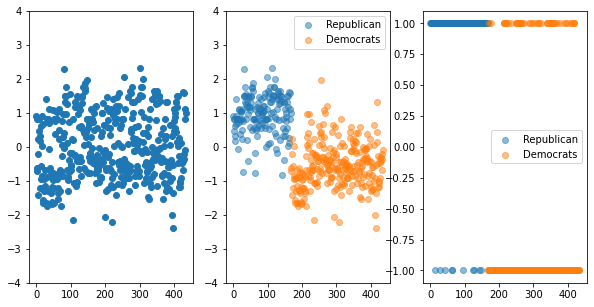

In [52]:
M_star = 6
J_star = 10
W = gaussian_weight(dist, sgm_star)

d = np.sum(W, axis=1)
D = np.diag(d)
L = D - W
ll, VV = np.linalg.eigh(L)
iddx = ll.argsort()
l = ll[iddx]
V = VV[:, iddx]
FX = V[:, :M_star]
# matrix A and vector b
A = FX[:J_star]
b = y[:J_star]

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(A, b)
# FX_b and y classifier
FX_b = np.dot(FX, reg.coef_)
sign_classifier = np.sign(FX_b)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
# the original scatter
ax[0].scatter(list(range(N)), FX_b)

# the first 168 republican, and then 267 democrats.
ax[1].scatter(list(range(len(idx[0]))), FX_b[idx[0]], cmap="hsv", alpha=0.5)
ax[1].scatter(list(range(len(idx[0]), N)), FX_b[idx[1]], cmap="jet", alpha=0.5)

# the y classifier on re-ordered X
ax[2].scatter(list(range(len(idx[0]))), sign_classifier[idx[0]], cmap="hsv", alpha=0.5)
ax[2].scatter(
    list(range(len(idx[0]), N)), sign_classifier[idx[1]], cmap="jet", alpha=0.5
)
ax[0].set_ylim(-4, 4)
ax[1].set_ylim(-4, 4)
ax[1].legend(["Republican", "Democrats"])
ax[2].legend(["Republican", "Democrats"])

In [ ]:
!pip install black[jupyter]
!black /content/drive/MyDrive/Colab\ Notebooks/amath\ 582\ lecture\ notes/reports\ /4/hw4.ipynb

/bin/bash: black: command not found
